In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools
from tools import cmp

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
# read in the crowley data
adata = sc.read_h5ad('dataset/Karthaus/karthaus_processed_epithelial.h5ad')
adata

AnnData object with n_obs × n_vars = 88993 × 4915
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

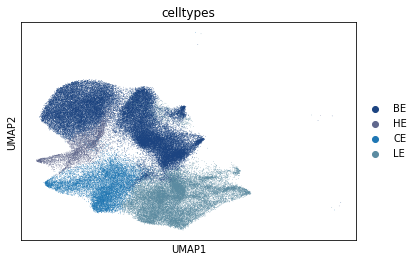

In [3]:
sc.pl.umap(adata, color = 'celltypes')

In [4]:
adata = adata[adata.obs['celltypes'].isin(['LE'])]
adata = adata.raw.to_adata()
adata.raw = adata

In [5]:
# read in the integrated mnp data
adata_ref = sc.read_h5ad('out/prostate_norm_220621.h5ad')
adata_ref = adata_ref[adata_ref.obs['celltype'].isin(['LE-KLK3', 'LE-KLK4'])]
adata_ref

View of AnnData object with n_obs × n_vars = 8166 × 21955
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF', 'Biopsy Location Co-ordinate', 'PMHx', 'celltype-immune'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

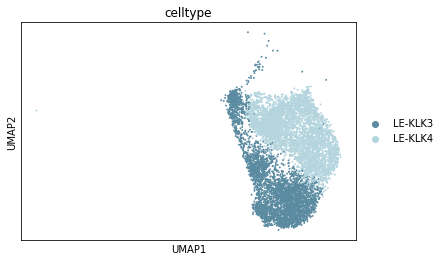

In [6]:
sc.pl.umap(adata_ref, color = 'celltype')

In [7]:
# quick process
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 23754 × 21940
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [9]:
sc.pp.highly_variable_genes(adata_ref, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_ref)
sc.external.pp.harmony_integrate(adata_ref, key = 'patient', adjusted_basis='X_pca')
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

extracting highly variable genes
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
2021-06-23 22:09:45,774 - harmonypy - INFO - Iteration 1 of 10
2021-06-23 22:09:48,947 - harmonypy - INFO - Iteration 2 of 10
2021-06-23 22:09:52,076 - harmonypy - INFO - Iteration 3 of 10
2021-06-23 22:09:54,032 - harmonypy - INFO - Converged after 3 iterations
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [10]:
sc.tl.ingest(adata, adata_ref, obs='celltype')

running ingest
    finished (0:01:19)


In [11]:
adata

AnnData object with n_obs × n_vars = 23754 × 21940
    obs: 'Barcode', 'batchID', 'pID', 'isTumorRegion', 'treatment', 'sortType', 'ver10x', 'batch', 'PatientNum', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R', 'celltypes', 'celltype'
    var: 'ID', 'Symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PatientNum_colors', 'batch_colors', 'celltypes_colors', 'hvg', 'isTumorRegion_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'

In [12]:
adata.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category colors

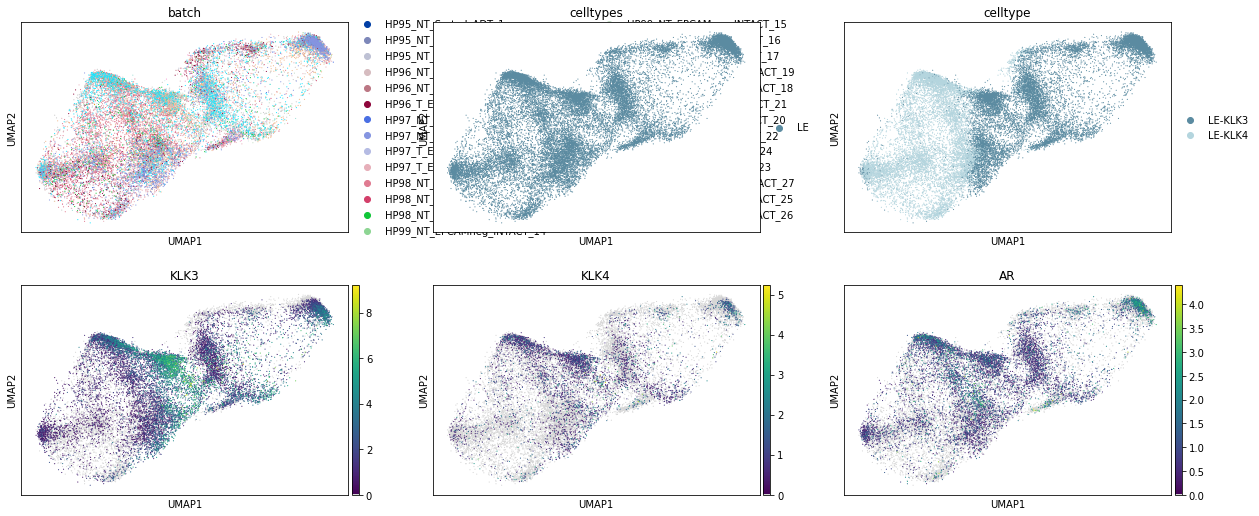

In [13]:
sc.pl.umap(adata, color = ['batch', 'celltypes', 'celltype', 'KLK3', 'KLK4', 'AR'], color_map = cmp(), ncols = 3)

In [14]:
# save
adata.write_h5ad('dataset/Karthaus/karthaus_processed_epithelial_ingested.h5ad', compression = 'gzip')